## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
not_treatment = df.query('landing_page == "new_page" & group != "treatment"')

In [8]:
not_np = df.query('landing_page != "new_page" & group == "treatment"')

In [13]:
not_treatment.count()+not_np.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [14]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [15]:
# from the quiz...in cases where we are unsure of the accuracy of the data
# we should remove it (only use rows we are confident about)
#df2 = df.drop(not_treatment)
df2 = df.drop(not_treatment.index)
df2 = df2.drop(not_np.index)

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [18]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [19]:
sum(df2.user_id.value_counts() > 1)

1

In [20]:
(df2.user_id.value_counts() > 1).head()

773192     True
630732    False
811737    False
797392    False
795345    False
Name: user_id, dtype: bool

c. What is the row information for the repeat **user_id**? 

In [21]:
#Find the dupes and list their row information in one step!
df2[df2.duplicated(subset='user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


###### OR WE CAN USE THIS 

In [22]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

### The reviewer suggested I try the following code. 
> When I looked it up in https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html
I found that the default parameter keep: is to drop duplicates except for the first occurrence

In [24]:
#df2.drop(index = 1899, axis = 0, inplace = True)
df2=df2.drop_duplicates("user_id")

In [25]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [26]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [27]:
df2[df2['group'] == "control"]['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [28]:
df2[df2['group'] == "treatment"]['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [29]:
df2.landing_page.count()

290584

In [30]:
df2.query('landing_page == "new_page"').count()

user_id         145310
timestamp       145310
group           145310
landing_page    145310
converted       145310
dtype: int64

In [31]:
# This answeres the probability that an indv rec a new page
# df2.query('landing_page == "new_page"').count()/df2.landing_page.count()
#  OR
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

In [32]:
#verify that the control group is only old_page (does not have new_page)
df2[df2['group'] == "control"]['landing_page'].value_counts()

old_page    145274
Name: landing_page, dtype: int64

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
>First, regardless of page the conversion rate is 0.1196

>If in the 'control group'(old_page), they had a 0.1204 probability of converting

>If in the 'treatment group'(new_page), then had an 0.1188 chance of converting

>finally .05001 probab that they received the new page

>So if half of the users are getting new page and half are getting old page...I still do not think there is  sufficent evidence to say that new treatment page leads to more conversions. **As it stands right now I would believe that the control group with its 12% prob of converting is getting just slightly better results. But it is not significantly better and it's difficult to say with certainty at this point**



<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
> H<sub>0</sub>: p<sub>old</sub> >= p<sub>new</sub>

> H<sub>1</sub>: p<sub>old</sub> < p<sub>new</sub>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [33]:
# These notes apply to the a. and b.
# This is a strange way to say "what is the assumed 
# convert rate regardless of page, regardless of group
# The converted rates will be equal as stated in the above paragraphs
# and as stated in my Part I section e.
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [34]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

### Note to self
> Notice that p_new - p_old under the null assumption = 0 

> That would be a trick question

c. What is $n_{new}$?

In [35]:
# I do not like the way this question is stated...
n_new = df2[df2['landing_page'] == "new_page"].shape[0]
n_new

145310

d. What is $n_{old}$?

In [36]:
n_old = df2[df2['landing_page'] == "old_page"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [37]:
# use new_page_converted
# numpy.random.binomial(n, p, size=None)
new_page_converted = np.random.binomial(n_new, p_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [38]:
old_page_converted = np.random.binomial(n_old, p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [39]:
#diff = new_page_converted - old_page_converted
diff = new_page_converted/n_new - old_page_converted/n_old
diff

0.00032818555865928023

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [40]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append((new_page_converted/n_new) - (old_page_converted/n_old))

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

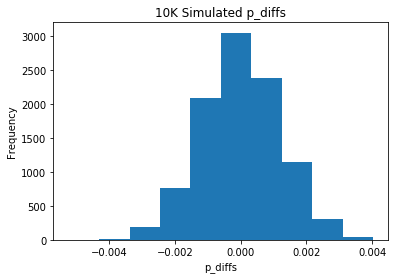

In [41]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('10K Simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [42]:
# From Part I sect 4
actual_diff_observed = df[df['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == "control"]['converted'].mean()

In [43]:
# 
#(p_diffs > actual_diff_observed).mean() -- this gave me an error bec p_diffs is a list and actual_diff_observed is a float()

p_diffs = np.array(p_diffs)          # so that I may do the comparison and get the mean()
(p_diffs > actual_diff_observed).mean() 

0.8914

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
* This computed value is the probability of finding the observed statistic (p_diffs . actual), when the null hypothesis is TRUE
* In section j. I just computed the p value.
* The P value is large and would not fit in our histogram, so it cannot defeat the null hypthesis


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. **Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.**

In [56]:
import statsmodels.api as sm
#convert_old = df2[df2['group'] == "control"]['converted'].sum()
#convert_new = df2[df2['group'] == "treatment"]['converted'].sum()
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

In [57]:
#use shape like before or len because you can;t do a sum on a column of text...and remember to shape[0]
# otherwise you get a tuple and the z test will fail
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [58]:
print(convert_old,convert_new,n_old,n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [59]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print(z_score)
print(p_value)

1.3109241984234394
0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
> The mean conversion rate (from j & k is .89)

* Z score is the standard deviation  from the mean
* A high P value indicates a non-significant result (menaing there is no better conversion rate for the newpage. The P Value is .905. Therefore we do not reject the Null Hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
* logsitic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [60]:
# creat an intercept column
df2['intercept'] = 1

In [61]:
# create dummy variable column
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

In [62]:
df2['ab_page'] = df2['treatment']

In [63]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [64]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [65]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:42:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**
* The p value associated with ab_page is 0.190
It differs from the P value in Part II because each test assumes a slightly different hypothesis
* in Part ii we are testing the assumption of conversion rates, specifically which one had a better conversion rate
* in Part iii we are doing regression testing which test if there was any effect


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**



g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [66]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [67]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1


In [68]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [69]:
### Create the necessary dummy variables
df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page,CA,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [70]:
### Fit Your Linear Model And Obtain the Results
df['intercept'] = 1

log_model = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])
results = log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        10:59:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

### Conclusions based on regression results
* Does it appear that country had an impact on conversion? 
>> P values for bot Canada and US are greater than the 0.05 acceptable error rate, so we can say that country does not have an impact on conversion